In [3]:
import os
from utils import PER

import vizdoom

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow import keras

In [2]:
def load_random_data(test=False, batch_size=32):
    
    random_video = np.random.randint(10)
    path = os.path.join("vizdoom_dataset")
    if test == True:
        random_video = np.random.randint(5)
        path = os.path.join("test")
    
    '''states = np.load(path+"\\states{}.npy".format(random_video), allow_pickle=True)
    actions = np.load(path+"\\actions{}.npy".format(random_video), allow_pickle=True)
    rewards = np.load(path+"\\rewards{}.npy".format(random_video), allow_pickle=True)
    n_states = np.load(path+"\\n_states{}.npy".format(random_video), allow_pickle=True)
    dones = np.load(path+"\\dones{}.npy".format(random_video), allow_pickle=True)'''
    states = np.load(path+"\\states{}.npy".format(0), allow_pickle=True)
    actions = np.load(path+"\\actions{}.npy".format(0), allow_pickle=True)
    rewards = np.load(path+"\\rewards{}.npy".format(0), allow_pickle=True)
    n_states = np.load(path+"\\n_states{}.npy".format(0), allow_pickle=True)
    dones = np.load(path+"\\dones{}.npy".format(0), allow_pickle=True)
    
    print(states.shape)
    
    video_len = dones.shape[0]
    random_video_indexes = np.random.randint(video_len-2, size=batch_size)
    #random_video_indexes = [x for x in range(32)]
    
    return states, actions, rewards, n_states, dones, random_video_indexes

In [58]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters = filters
        self.strides = strides
        self.main_layers = [
            keras.layers.Conv2D(filters, kernel_size=3, strides=strides,
                               padding="same", use_bias=False, kernel_initializer = "he_normal"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, kernel_size=3, strides=1,
                               padding="same", use_bias=False, kernel_initializer = "he_normal")]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, kernel_size=1, strides=strides,
                               padding="same", use_bias=False, kernel_initializer = "he_normal"),
                keras.layers.BatchNormalization()]
            
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 
                "filters": self.filters,
                "strides": self.strides,
                "activation": keras.activations.serialize(self.activation)}

In [261]:
input_shape = (64, 64, 4)
n_outputs = 7
loss_fn = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(lr=1e-3)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=8, strides=2, 
                              padding="valid", input_shape=input_shape, kernel_initializer="he_normal"))
model.add(keras.layers.Activation("relu"))

#prev_filters = 32
#for filters in [64] * 1 + [128] * 2:
    #strides = 1 if filters == prev_filters else 2
    #model.add(ResidualUnit(filters, strides=strides))
    #prev_filters = filters

model.add(keras.layers.Conv2D(64, kernel_size=4, strides=2, 
                              padding="valid", kernel_initializer="he_normal"))
model.add(keras.layers.Activation("relu"))

model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, 
                              padding="valid", kernel_initializer="he_normal"))
model.add(keras.layers.Activation("relu"))

#model.add(keras.layers.Flatten())
model.add(keras.layers.Reshape((1, -1)))

model.add(keras.layers.LSTM(512, return_sequences=True))
model.add(keras.layers.LSTM(256, return_sequences=False))
model.add(keras.layers.Dense(64, activation="tanh", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(n_outputs, activation="softmax"))

model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-3))

#target_model = keras.models.clone_model(model)
#target_model.set_weights(model.get_weights())

per = PER(5000)

In [262]:
def find_n_step_return(states, rewards, dones, random_video_index):
    frames_left = dones.shape[0] - random_video_index
    gamma = 0.95
    n_step_return = 0

    if frames_left < 10:
        n = frames_left
    else:
        n = 10
    
    if dones[random_video_index + n - 1] != 1:
        n_step_state = states[random_video_index + n - 1]
    else:
        n_step_state = states[-1]
        
    n_step_state = np.array(Image.fromarray(n_step_state, "RGB").resize((64, 64)).convert("L"))

    for i in range(n):
        n_step_return += (gamma**i) * (rewards[random_video_index + i])

    n_step_return += (gamma ** n) * np.max(model(n_step_state[np.newaxis]))

    print("N step return: ", n_step_return)
    return n_step_return

In [263]:
def training_step(target_model, model, loss_fn=loss_fn, optimizer=optimizer, prefill=False, rl=True):
    discount_factor = 0.95
    
    states, actions, rewards, n_states, dones, rand_idx = load_random_data()
    
    if rl is not False:
        n_step_rewards = find_n_step_return(states, rewards, dones, rand_idx)
        per.store([image_processor(states[rand_idx]), 
                   actions[rand_idx], n_step_rewards, 
                   image_processor(n_states[rand_idx]), dones[rand_idx]])

        BATCH_SIZE = 32
        tree_idx, experiences, ISWeights_mb = per.sample(BATCH_SIZE)
        xp = experiences

        states, actions, n_step_rewards, n_states, dones = np.array([i[0][0] for i in xp]), np.array([i[0][1] for i in xp]), np.array([i[0][2] for i in xp]), np.array([i[0][3] for i in xp]), np.array([i[0][4] for i in xp])
        
        print(states.shape)
        states = states.reshape(BATCH_SIZE, 64, 64, 4)
        n_states = n_states.reshape(BATCH_SIZE, 64, 64, 4)
    
    if prefill == False:
        batched_states = np.array([states[x] for x in rand_idx])
        print(batched_states.shape)
        batched_actions = np.array([actions[x] for x in rand_idx])
        model.train_on_batch(batched_states, batched_actions)
        supervised_preds = model(batched_states)
        supervised_loss = keras.losses.BinaryCrossentropy(from_logits=False)(batched_actions, supervised_preds)
        print("Supervised loss: ", supervised_loss.numpy())
        
        if rl is not False:
            next_Q_values = target_model.predict(n_states)
            max_next_Q_values = np.max(next_Q_values, axis=1)
            target_Q_values = (n_step_rewards + 
                              (1 - dones) * discount_factor * max_next_Q_values)
            mask = actions

            print(states[-1].shape)


            with tf.GradientTape() as tape:
                all_Q_values = model(states)

                Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
                
                loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
                print("Total loss: ", loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            abs_error = tf.abs(target_Q_values - Q_values)
            per.batch_update(tree_idx, abs_error)

            return loss

In [264]:
def supervised_training(model, epochs=200):
    for epoch in range(epochs):
        print("Epoch: ", epoch+1)
        training_step(None, model, rl=False)
        
supervised_training(model)

Epoch:  1
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.3800877
Epoch:  2
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.30859032
Epoch:  3
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.23290524
Epoch:  4
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.2635342
Epoch:  5
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.30641705
Epoch:  6
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.2620629
Epoch:  7
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.3076616
Epoch:  8
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.26401156
Epoch:  9
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.2876913
Epoch:  10
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.26665652
Epoch:  11
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.23748723
Epoch:  12
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.30761155
Epoch:  13
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.26349017
Epoch:  14
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.2

Supervised loss:  0.16228436
Epoch:  114
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.12877887
Epoch:  115
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.15947576
Epoch:  116
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.15255973
Epoch:  117
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.12718305
Epoch:  118
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.15052234
Epoch:  119
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.13579972
Epoch:  120
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.137454
Epoch:  121
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.14576186
Epoch:  122
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.15899019
Epoch:  123
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.106374994
Epoch:  124
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.11425624
Epoch:  125
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.12928906
Epoch:  126
(412, 64, 64, 4)
(32, 64, 64, 4)
Supervised loss:  0.08544208
Epoch:  12

In [265]:
def prefill_per(target_model, model, times=100):
    for time in range(times):
        print("Prefilled: ", time + 1)
        training_step(target_model, model, prefill=True)

#prefill_per(target_model, model)

In [ ]:
def train_model(target_model, model, tau=50, n_epochs=50):
    all_loss = []
    for epoch in tf.range(n_epochs):
        print("Epoch: ", epoch + 1)
        loss = training_step(target_model, model, prefill=False)
        all_loss.append(float(loss))
        if epoch % tau == 0:
            target_model.set_weights(model.get_weights())
            
    plt.plot(all_loss)
    plt.show()
        
train_model(target_model, model)

In [269]:
from sklearn.manifold import TSNE

states, actions, rewards, n_states, dones, rand_idx = load_random_data()
X_valid_compressed = model.predict(states)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

(412, 64, 64, 4)


In [270]:
print([np.argmax(x) for x in actions])

[0, 0, 0, 0, 0, 0, 5, 5, 5, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 5, 5, 5, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 5, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 6, 6, 6, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 2, 2, 0, 0, 0, 6, 6, 6, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 6, 6, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 2, 2, 0, 0, 0, 2, 2, 2, 2, 5, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 

(412, 7)


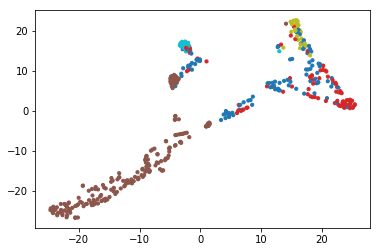

In [271]:
print(actions.shape)
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=[np.argmax(x) for x in actions], s=10, cmap="tab10")
plt.show()

In [272]:
model.save("test.h5")

In [273]:
model.summary()

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 29, 29, 32)        8224      
_________________________________________________________________
activation_119 (Activation)  (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 13, 13, 64)        32832     
_________________________________________________________________
activation_120 (Activation)  (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 6, 6, 128)         73856     
_________________________________________________________________
activation_121 (Activation)  (None, 6, 6, 128)         0         
_________________________________________________________________
reshape_47 (Reshape)         (None, 1, 4608)         

In [274]:
agent = keras.models.load_model("test.h5", custom_objects={"ResidualUnit":ResidualUnit})

(412, 64, 64, 4)


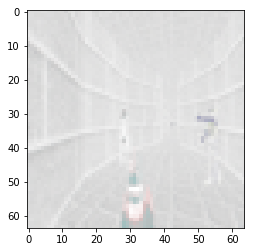

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


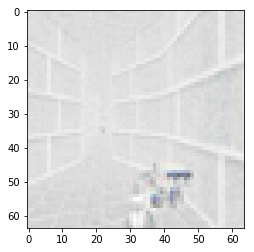

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


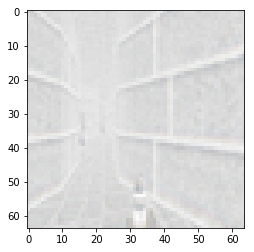

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


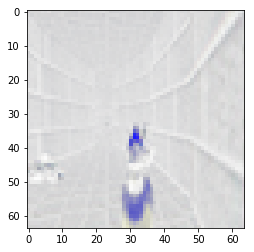

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


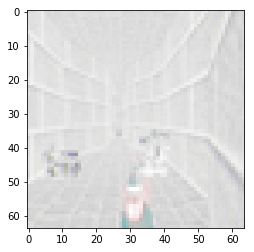

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 1 0]
(412, 64, 64, 4)


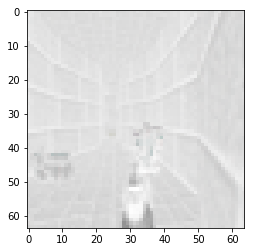

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 1 0]
(412, 64, 64, 4)


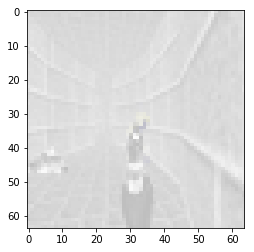

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


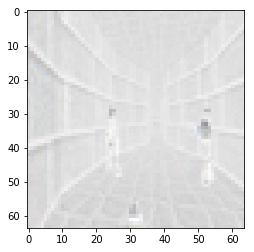

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


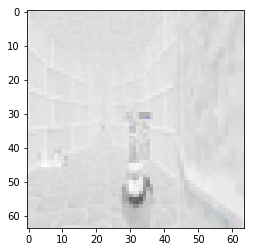

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


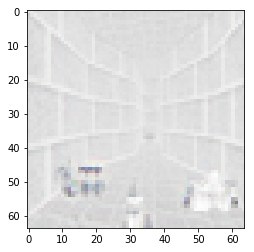

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


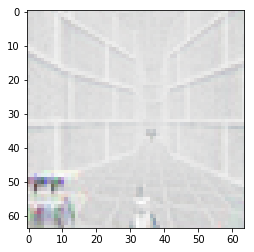

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 1]
(412, 64, 64, 4)


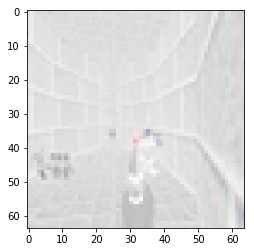

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


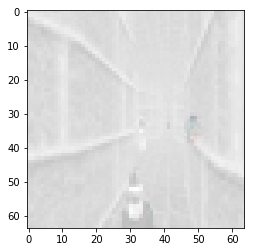

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


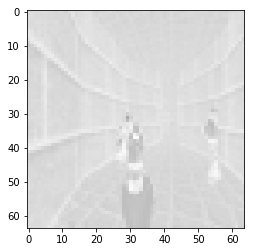

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


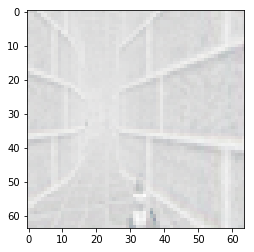

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


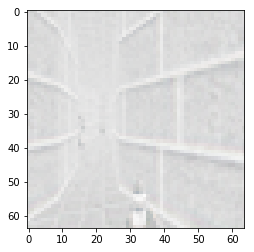

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


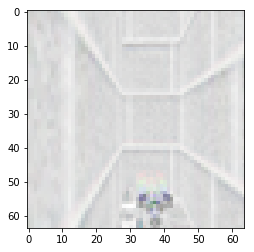

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


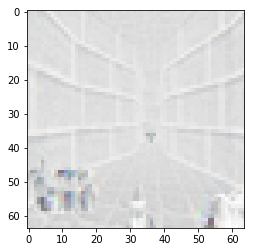

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


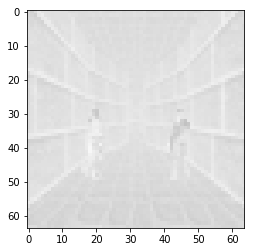

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


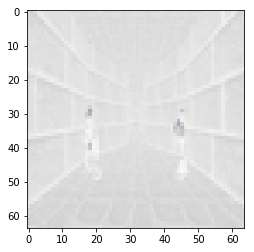

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 1 0]
(412, 64, 64, 4)


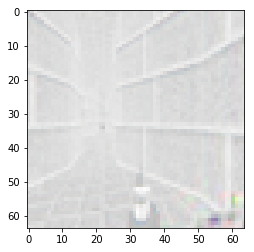

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


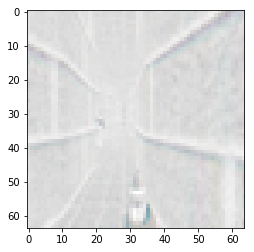

Guessed action:  [[0. 0. 0. 0. 0. 1. 0.]]
Actual action:  [0 0 0 0 0 1 0]
(412, 64, 64, 4)


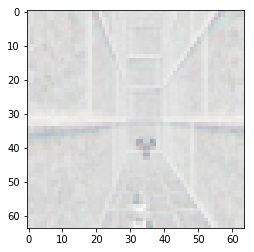

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


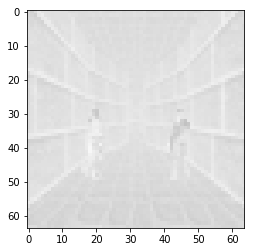

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 0]
(412, 64, 64, 4)


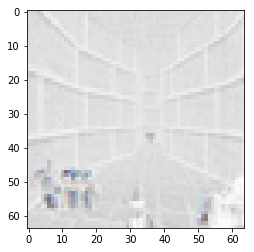

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


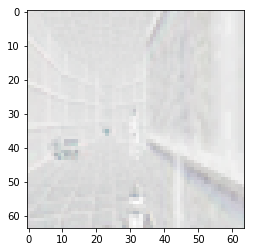

Guessed action:  [[0. 0. 1. 0. 0. 0. 0.]]
Actual action:  [0 0 1 1 0 0 0]
(412, 64, 64, 4)


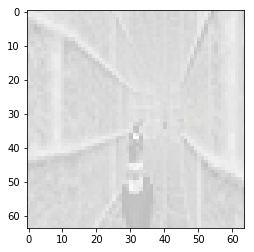

Guessed action:  [[0. 0. 0. 0. 0. 0. 1.]]
Actual action:  [0 0 0 0 0 0 1]
(412, 64, 64, 4)


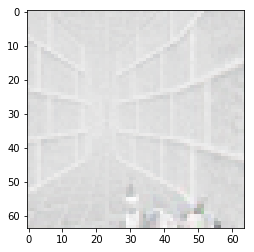

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


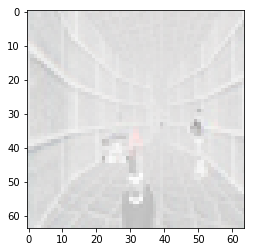

Guessed action:  [[0. 0. 0. 0. 0. 0. 0.]]
Actual action:  [0 0 0 0 0 0 1]
(412, 64, 64, 4)


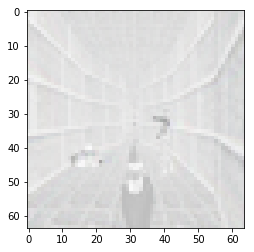

Guessed action:  [[0. 0. 0. 0. 0. 0. 1.]]
Actual action:  [0 0 1 0 0 0 1]
(412, 64, 64, 4)


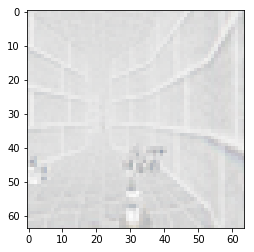

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 0 0]
(412, 64, 64, 4)


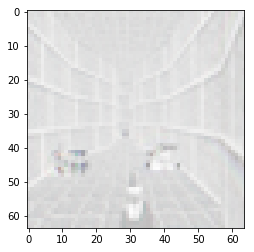

Guessed action:  [[0. 0. 0. 1. 0. 0. 0.]]
Actual action:  [0 0 0 1 0 1 0]


In [275]:
for i in tf.range(32):
    states, actions, rewards, n_states, dones, rand_idx = load_random_data()
    test_img = states[rand_idx[i]]
    plt.imshow(test_img)
    plt.show()
    
    action = agent(test_img[np.newaxis])
    acc_action = actions[rand_idx[i]]
    
    print("Guessed action: ", np.round(action))
    print("Actual action: ", acc_action)